In [1]:
import re

def parse_obj(txt, scale=10):
    lines = txt.split('\n')
    v = [line for line in lines if line.startswith("v ")]
    f = [
        list(reversed([int(idx) - 1 for idx in re.split(r'\s+', line)[1:4]]))
        for line in lines if line.startswith("f ")
    ]
    
    vertices = [
        [scale * float(coord) for coord in re.split(r'\s+', line)[1:4]]
        for line in v
    ]
    
    return vertices, f

In [2]:
import requests

url = "https://enki.ws/bunny_low.obj"
response = requests.get(url)

if response.status_code == 200:
    obj_data = response.text
    vertices, f = parse_obj(obj_data)
    print("fetched")
else:
    print("Failed to fetch OBJ file")


fetched


In [3]:
import json
# Serialize and save
with open("./mesh_data/bunny_vertices.json", "w") as vf:
    json.dump(vertices, vf)
with open("./mesh_data/bunny_faces.json", "w") as ff:
    json.dump(f, ff)

In [4]:
vertices[:3], f[:3]

([[-0.0949059, 1.29542, 0.22747199999999998],
  [-0.299386, 1.7763399999999998, -0.0482554],
  [0.170187, 1.18773, 0.35285200000000005]],
 [[281, 331, 266], [621, 619, 595], [175, 59, 245]])

In [5]:
# 3d vectors to pga points
from gc_utils import *
alg = Algebra(3, 0, 1)
locals().update(alg.blades)

origin = e0 # say the 3d origin is (0, -1, 0)
v1, v2, v3 = [(origin + alg.vector((0, *p))).dual() for p in [[1,2,3], [4,5,6], [0,0,0]]]
v1, v2, v3

(-3 𝐞₀₁₂ + 2 𝐞₀₁₃ + -1 𝐞₀₂₃ + 1 𝐞₁₂₃,
 -6 𝐞₀₁₂ + 5 𝐞₀₁₃ + -4 𝐞₀₂₃ + 1 𝐞₁₂₃,
 1 𝐞₁₂₃)

In [6]:
# lines/faces as pga join
v1 & v2, v1 & v2 & v3

(-3 𝐞₀₁ + 6 𝐞₀₂ + -3 𝐞₀₃ + 3 𝐞₁₂ + -3 𝐞₁₃ + 3 𝐞₂₃, -3 𝐞₁ + 6 𝐞₂ + -3 𝐞₃)

### Half Edge Mesh
1. Orientation, Connectivity
2. an oriented edge ij != ji
3. key functions: twin, next

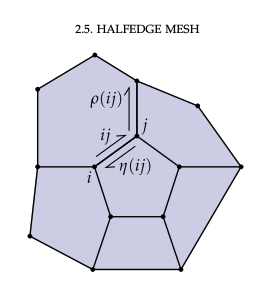 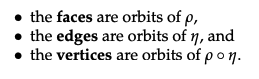

In [7]:
from gc_utils import *
alg = Algebra(3, 0, 1)
locals().update(alg.blades)

def half_edge(mesh):
    pts, faces = mesh
    HE = []
    
    # Process points: vector to pga point
    pts = [(e0+alg.vector((0, *p))-e2).dual() for p in pts]
    
    # Process faces: pga join
    faces = []
    for i, (v1, v2, v3) in enumerate(mesh[1]):
        face = {"vtx": [v1, v2, v3], "plane": pts[v1] & pts[v2] & pts[v3], "idx": i}
        HE.extend([
            {"from": v1, "to": v2, "line": pts[v1] & pts[v2], "face": face},
            {"from": v2, "to": v3, "line": pts[v2] & pts[v3], "face": face},
            {"from": v3, "to": v1, "line": pts[v3] & pts[v1], "face": face}
        ])
        
        face["edge"] = i * 3 + 2
        for j in range(3):
            HE[i * 3 + ((j + 2) % 3)]["next"] = HE[i * 3 + ((j + 1) % 3)]["prev"] = i * 3 + j
        
        faces.append(face)
    
    # An vertex gets assigned several times of half-edges
    vertex_list = [None] * len(pts)
    for idx, E in enumerate(HE):
        E["idx"] = idx
        vertex_list[E["from"]] = {"vtx": pts[E["from"]], "edge": idx}
    # Assign twin edges using a dictionary for efficient lookup
    edge_map = {}
    for idx, E in enumerate(HE):
        key = (E["from"], E["to"])
        edge_map[key] = idx

    for idx, E in enumerate(HE):
        twin_key = (E["to"], E["from"])
        twin_idx = edge_map.get(twin_key)
        E["twin"] = twin_idx
    
    return vertex_list, HE, faces

pts, HE, faces = half_edge((vertices, f))

In [8]:
len(faces), len(HE), len(pts), faces[0], pts[281], HE[2]

(1250,
 3750,
 627,
 {'vtx': [281, 331, 266],
  'plane': 0.0016 𝐞₀ + -0.00448 𝐞₁ + -0.00835 𝐞₂ + -0.00332 𝐞₃,
  'idx': 0,
  'edge': 2},
 {'vtx': 0.392 𝐞₀₁₂ + 0.743 𝐞₀₁₃ + 0.736 𝐞₀₂₃ + 1 𝐞₁₂₃, 'edge': 3473},
 {'from': 266,
  'to': 281,
  'line': 0.0535 𝐞₀₁ + 0.0771 𝐞₀₂ + 0.0455 𝐞₀₃ + 0.0634 𝐞₁₂ + -0.0164 𝐞₁₃ + -0.0776 𝐞₂₃,
  'face': {'vtx': [281, 331, 266],
   'plane': 0.0016 𝐞₀ + -0.00448 𝐞₁ + -0.00835 𝐞₂ + -0.00332 𝐞₃,
   'idx': 0,
   'edge': 2},
  'next': 0,
  'prev': 1,
  'idx': 2,
  'twin': 1564})

In [9]:
# Line integral of a cummulative function f around a face p
# start from a starting edge through the half edges back to the starting edge
# Or if p is a vertex, "Line integral" along the star of p

def edges(p, f, s=None):
    idx = p["edge"]
    e = HE[idx]
    while True:
        s = f(e, s)
        e = HE[e["next"]] if p.get("plane") else HE[HE[e["twin"]]["next"]]
        if e["idx"] == p["edge"]:
            return s

In [10]:
def append_from_to(e, s):
    s = s or []
    s.append((e["from"], e["to"]))
    return s

{
    'edges around a face': edges(faces[0], append_from_to), 
    'star of a vertex': edges(pts[281], append_from_to)
    }

{'edges around a face': [(266, 281), (281, 331), (331, 266)],
 'star of a vertex': [(281, 385), (281, 298), (281, 266), (281, 331)]}

In [11]:
def append_face(e, s):
    s = s or []
    s.append(e['face']['idx'])
    return s
faces_around = edges(pts[281], append_face)
faces_around

[1157, 519, 521, 0]

### Discretization
How to discretize?

'There is no one “right” way
to discretize a given geometric quantity, but rather many different ways, each suited to a particular

purpose.'

We don't compute exterior derivative directly. 

But by repeated stokes theorem:

measure on faces -> edges (-> vertices)

So the problem becomes assigning weights to edges (to vertices)

A weight depends on its connections e.g.
1. the distance from surrounding vertices
2. relative angle/length from surrounding edges/faces

??? Since we assign connectivity by half edges, we'd prefer integral over edges.

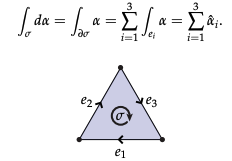

### Vector Area
The vector area is encode by a pga plane, or from a line integral on the boundary:

Within a simplicial mesh, we just need to 

In [12]:
# Besides the vector area, a pga plane also gives the distance from the origin
face = faces[0]
face['plane'], norm(face['plane'])

(0.0016 𝐞₀ + -0.00448 𝐞₁ + -0.00835 𝐞₂ + -0.00332 𝐞₃, 0.01004041903100847)

In [27]:
def cross_ends(e, s):
    if s is None:
        s = np.zeros(3)
    i = e['from']
    j = e['to']
    s += np.cross(vertices[i], vertices[j])
    return s

va = edges(faces[0], cross_ends)
va, np.linalg.norm(va)

(array([-0.00448348, -0.00834668, -0.00332285]), 0.010040419031008493)

In [25]:
def _line(e, s=0):
    s += e['line']
    return s

va = edges(faces[0], _line)
va, norm(va.dual())

(-0.00448 𝐞₀₁ + -0.00835 𝐞₀₂ + -0.00332 𝐞₀₃, 0.010040419031008507)

In [16]:
# For several faces, just a summation
def faces_plane_sum(idx_list):
    return sum(faces[i]['plane'] for i in idx_list)

plane_sum = faces_plane_sum(faces_around)
plane_sum, norm(plane_sum)

(0.0173 𝐞₀ + -0.0054 𝐞₁ + -0.0362 𝐞₂ + -0.0144 𝐞₃, 0.03933952328828597)

In [17]:
va_sum = sum(edges(faces[i], _line) for i in faces_around)
va_sum, norm(va_sum.dual())

(-0.0054 𝐞₀₁ + -0.0362 𝐞₀₂ + -0.0144 𝐞₀₃, 0.03933952328828601)

In [ ]:
# We can eliminates the opposite half edges above. 
# And do the line integral just on the link of the vertex.
def link_line(e, s):
    if s is None:
        s = 0
    e = HE[e['next']]
    s += e['line']
    return s

edges(pts[281], link_line)

-0.0054 𝐞₀₁ + -0.0362 𝐞₀₂ + -0.0144 𝐞₀₃

### Vertex Normal as Area/Volume Gradient
#### Cotangent formula for the Area Gradient
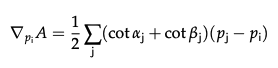
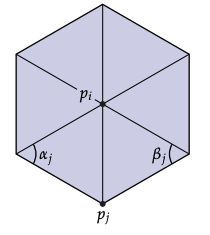

In [19]:
cotan = lambda h: (HE[h['next']]['line'] | HE[h['prev']]['line'])[0] / norm(h['face']['plane'])
cotan(HE[0])

0.6707622592444273

Numerically verify this formua? By updating faces around the point.

In [20]:
e = HE[pts[0]['edge']]
e['face']['plane']

0.0104 𝐞₀ + 0.00726 𝐞₁ + -0.0323 𝐞₂ + -0.000777 𝐞₃

In [21]:
def edge_area(e, s):
    s = s or 0
    s += norm(e['face']['plane'])
    return s

def edge_area_updated(e, s):
    s = s or 0
    v1, v2, v3 = e['face']['vtx']
    plane = pts[v1]['vtx'] & pts[v2]['vtx'] & pts[v3]['vtx']
    s += norm(plane)
    return s

edges(pts[0], edge_area), edges(pts[0], edge_area_updated)
    

(0.14376504116536087, 0.14376504116536087)

In [22]:
frame = [e.dual() for e in [e1, e2, e3]] # 3d for translating a point
frame

def point_area(x):
    temp_pt = pts[0]
    temp_pt['vtx'] = pts[0]['vtx'] + x
    return edges(temp_pt, edge_area_updated)

derivative(point_area, 0, alg, frame=frame, r_frame=frame)

-0.0219 𝐞₀₁₂ + 0.0903 𝐞₀₁₃ + 0.0208 𝐞₀₂₃

In [ ]:
def area_gradient(e, s):
    if s is None:
        s = 0
    # times e0 to drop out the positional information
    s += (cotan(e) + cotan(HE[e["twin"]])) * e['line'] * e0 / 2
    return s

gradient = edges(pts[0], area_gradient)
gradient

-0.0219 𝐞₀₁₂ + 0.0903 𝐞₀₁₃ + 0.0208 𝐞₀₂₃

In [24]:
def area_gradient_position(e, s):
    if s is None:
        s = 0
    s += (cotan(e) + cotan(HE[e["twin"]])) * e['line'] / 2
    return s

edges(pts[0], area_gradient_position), pts[0]['vtx'] * gradient.dual()

(0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃ + -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃,
 0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃ + -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃ + 0.0336 𝐞₀₁₂₃)

PGA derivative? For translating a point, we use a "3d" frame

    [e.dual() for e in [e1, e2, e3]]

But for other geometic object? 

A bivector describes a rigid body motion, so for general approach we should use a bivector frame. In 3d-PGA, the bivector subspace is 6 dimensional. We can further split it into rotation and translation. Each of 3 dimension, which gives another reason of the "3d" frame we chose for translating a point.


In [35]:
frame = r_vector_frame(alg.frame, 2)
r_frame = [e.dual() for e in frame]

def point_area(b):
    temp_pt = pts[0]
    temp_pt['vtx'] = blade_exp(b/2).sw(pts[0]['vtx'])
    return edges(temp_pt, edge_area_updated)

derivative(point_area, 0, alg, frame=frame, r_frame=r_frame)

0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃ + -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃

In [36]:
# The rotational bivectors contribute to the position of the gradient. Why?
# It's a rotation of the whole space, with an axis through the orign
(
    frame, r_frame, 
    derivative(point_area, 0, alg, frame=frame[:3], r_frame=r_frame[:3]),
    derivative(point_area, 0, alg, frame=frame[3:], r_frame=r_frame[3:])
    )

([1 𝐞₀₁, 1 𝐞₀₂, 1 𝐞₀₃, 1 𝐞₁₂, 1 𝐞₁₃, 1 𝐞₂₃],
 [1 𝐞₂₃, -1 𝐞₁₃, 1 𝐞₁₂, 1 𝐞₀₃, -1 𝐞₀₂, 1 𝐞₀₁],
 -0.0219 𝐞₁₂ + 0.0903 𝐞₁₃ + 0.0208 𝐞₂₃,
 0.0141 𝐞₀₁ + 0.00266 𝐞₀₂ + 0.00241 𝐞₀₃)

### Volume Gradient
In PGA, just sum of faces

In [37]:
def vol_gradient(e, s):
    if s is None:
        s = 0
    s += e['face']['plane']/6
    return s

vol_grad = edges(pts[0], vol_gradient)
vol_grad

0.00816 𝐞₀ + 0.00519 𝐞₁ + -0.0223 𝐞₂ + -0.00482 𝐞₃

In [ ]:
# The normal form area gradient and volume gradient are different but not far
normalize(gradient.dual()), normalize(vol_grad)

(0.219 𝐞₁ + -0.948 𝐞₂ + -0.23 𝐞₃, 0.35 𝐞₀ + 0.222 𝐞₁ + -0.953 𝐞₂ + -0.206 𝐞₃)

### Discrete Hodge Star:
1. dual mesh
2. discrete primal and dual forms live in different places (no summation)

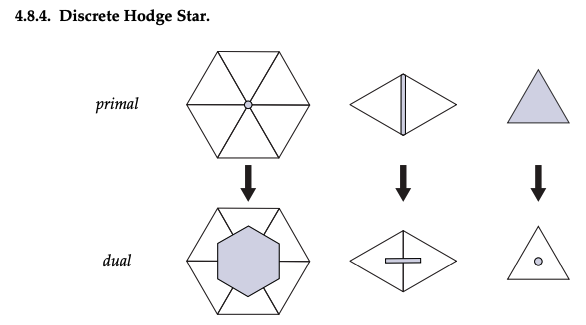


When doing integration, a dual mesh may provide a measure to each discrete element.

### Some ideas
The discretization of differential forms is a choice of how to integrate differential forms. Differentail form is a limited part of GC. We've seen some computations in GA doing the same thing as differential form. But GA provides richer structure and insights of the geometry. We need inspect the integration theory of GA to...

#### Neural k-form
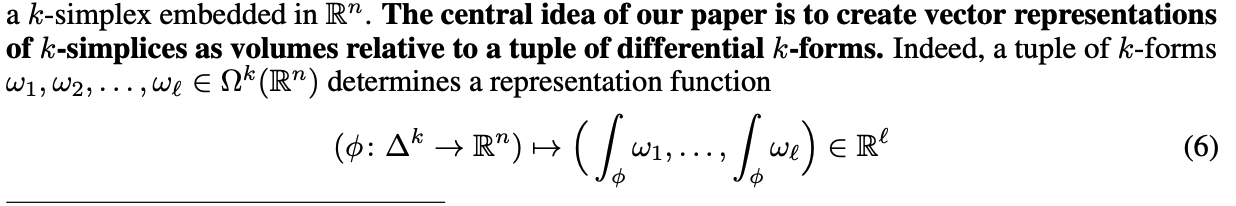

We use a multiform instead of a tuple of k-forms. A multiform can be split into a tuple by a multivector basis, which could preserve more structure if we pass through the knowledge of the multivector:
1. designing a data structure
2. training to understand multivectors